In [135]:
import argparse
import logging
import time
import random
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

from heston_chebyshev_tt import HestonChebyshevTTPricer

sns.set_theme(style="whitegrid", palette='deep')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(filename)s - %(message)s')
logging.getLogger().setLevel(logging.INFO)

In [88]:
def perform_stress_test():
    parameter_limits = {
        'S': [80.0, 120.0],
        'K': [80.0, 120.0],
        'T': [0.1, 2.0],
        'sigma_v': [0.1, 1.0],
        'kappa': [0.5, 5.0],
        'rho': [-0.9, -0.1],
        'theta': [0.01, 0.1],
        'v0': [0.01, 0.2],
        'rate': [0.01, 0.1],
        'div': [0.0, 0.05]
    }

    n_test = 100
    test_samples = {
        k: [random.uniform(v[0], v[1]) for _ in range(n_test)] for k, v in parameter_limits.items()
    }
    test_samples['batch_size'] = n_test

    interpolation_order = 8
    n = len(parameter_limits.keys())
    dimensions = np.arange(1, n + 1)

    offline_times = []
    online_times = []
    max_ranks = []
    max_abs_errors = []
    rms_errors = []
    n_samples = []

    for i in range(n):

        logging.info(f'Starting stress test with {i+1} variable parameters out of {n}')

        variable_parameters = dict(list(parameter_limits.items())[:i+1])
        fixed_parameters_list = list(parameter_limits.items())[i+1:11]

        fixed_parameters = {k: round((v[0] + v[1])/2, 3) for k, v in fixed_parameters_list}

        pricer = HestonChebyshevTTPricer(
            fixed_params=dict(fixed_parameters),
            variable_params=dict(variable_parameters),
            interpolation_order=interpolation_order,
            tt_rmax=250,
            tt_max_iter=40,
            tt_eps=1E-3,
            tt_early_stopping_tolerance= 7E-5,
            tt_early_stopping_patience=4
        )

        pricer.offline_phase()
        offline_phase_time = pricer.get_eval_time()
        offline_times.append(offline_phase_time)
        logging.info(f'Offline phase for {list(variable_parameters.keys())} took {offline_phase_time:.2f} seconds')

        max_ranks.append(pricer.get_max_tt_rank())
        n_samples.append(pricer.get_n_samples())

        tt_prices = []
        start_time = time.time()
        for sample in range(n_test):
            test_params = {**{k: test_samples[k][sample] for k in variable_parameters.keys()}, **fixed_parameters}
            price = pricer.price(test_params)
            tt_prices.append(price)
        online_phase_time = (time.time() - start_time) / n_test
        online_times.append(online_phase_time)
        logging.info(f'Online phase for {list(variable_parameters.keys())} took {online_phase_time:.8f} seconds')

        analytical_prices = pricer.fft_pricer(**{**test_samples, **fixed_parameters})
        logging.info(f'Analytical prices for {list(variable_parameters.keys())} computed')

        max_abs_error = max(abs(a - t) for a, t in zip(analytical_prices, tt_prices))
        max_abs_errors.append(max_abs_error)
        rms_error = (sum((a - t) ** 2 for a, t in zip(analytical_prices, tt_prices)) / n_test) ** 0.5
        rms_errors.append(rms_error)
        logging.info(f'Max absolute error: {max_abs_error:.6f}, RMS error: {rms_error:.6f}')

    return offline_times, online_times, max_ranks, max_abs_errors, rms_errors, n_samples

In [89]:
from tqdm import tqdm_notebook as tqdm
offline_times, online_times, max_ranks, max_abs_errors, rms_errors, n_samples = perform_stress_test()

2025-06-30 10:50:52,398 - root - INFO - 2501977658.py - Starting stress test with 1 variable parameters out of 10


cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 1D domain containing 9 grid points:
iter: 0  

2025-06-30 10:50:52,623 - root - INFO - 2501977658.py - Offline phase for ['S'] took 0.01 seconds
2025-06-30 10:50:52,628 - root - INFO - 2501977658.py - Online phase for ['S'] took 0.00004451 seconds
2025-06-30 10:50:52,642 - root - INFO - 2501977658.py - Analytical prices for ['S'] computed
2025-06-30 10:50:52,642 - root - INFO - 2501977658.py - Max absolute error: 0.000014, RMS error: 0.000008
2025-06-30 10:50:52,642 - root - INFO - 2501977658.py - Starting stress test with 2 variable parameters out of 10


| eps: 0.000e+00 | time:   0.0102 | largest rank:   1 <- converged: eps < 0.001
Did 9 function evaluations, which took 0.002172s (4144 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 2D domain containing 81 grid points:
iter: 0  | eps: 1.284e-01 | time:   0.0153 | largest rank:   1
iter: 1  

2025-06-30 10:50:52,827 - root - INFO - 2501977658.py - Offline phase for ['S', 'K'] took 0.04 seconds
2025-06-30 10:50:52,833 - root - INFO - 2501977658.py - Online phase for ['S', 'K'] took 0.00005655 seconds
2025-06-30 10:50:52,850 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K'] computed
2025-06-30 10:50:52,851 - root - INFO - 2501977658.py - Max absolute error: 0.005844, RMS error: 0.001966
2025-06-30 10:50:52,851 - root - INFO - 2501977658.py - Starting stress test with 3 variable parameters out of 10


| eps: 8.454e-05 | time:   0.0388 | largest rank:   4 <- converged: eps < 0.001
Did 135 function evaluations, which took 0.02419s (5580 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 3D domain containing 729 grid points:
iter: 0  | eps: 2.847e-01 | time:   0.0185 | largest rank:   1
iter: 1  | eps: 2.720e-03 | time:   0.1530 | largest rank:   4
iter: 2  

2025-06-30 10:50:53,831 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T'] took 0.62 seconds
2025-06-30 10:50:53,850 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T'] took 0.00018288 seconds
2025-06-30 10:50:53,895 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T'] computed
2025-06-30 10:50:53,896 - root - INFO - 2501977658.py - Max absolute error: 0.008539, RMS error: 0.002610
2025-06-30 10:50:53,900 - root - INFO - 2501977658.py - Starting stress test with 4 variable parameters out of 10


| eps: 4.103e-05 | time:   0.6196 | largest rank:   7 <- converged: eps < 0.001
Did 1512 function evaluations, which took 0.5936s (2547 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 4D domain containing 6561 grid points:
iter: 0  | eps: 2.777e-01 | time:   0.0343 | largest rank:   1
iter: 1  | eps: 3.666e-03 | time:   0.4433 | largest rank:   4
iter: 2  

2025-06-30 10:50:56,115 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v'] took 1.62 seconds
2025-06-30 10:50:56,136 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v'] took 0.00020799 seconds
2025-06-30 10:50:56,202 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v'] computed
2025-06-30 10:50:56,204 - root - INFO - 2501977658.py - Max absolute error: 0.023794, RMS error: 0.004952
2025-06-30 10:50:56,205 - root - INFO - 2501977658.py - Starting stress test with 5 variable parameters out of 10


| eps: 3.251e-04 | time:   1.6242 | largest rank:   7 <- converged: eps < 0.001
Did 2700 function evaluations, which took 1.572s (1718 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 5D domain containing 59049 grid points:
iter: 0  | eps: 2.831e-01 | time:   0.0434 | largest rank:   1
iter: 1  | eps: 9.231e-03 | time:   0.8193 | largest rank:   4
iter: 2  

2025-06-30 10:50:59,533 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa'] took 2.79 seconds
2025-06-30 10:50:59,550 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa'] took 0.00016523 seconds
2025-06-30 10:50:59,625 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa'] computed
2025-06-30 10:50:59,626 - root - INFO - 2501977658.py - Max absolute error: 0.069973, RMS error: 0.015248
2025-06-30 10:50:59,627 - root - INFO - 2501977658.py - Starting stress test with 6 variable parameters out of 10


| eps: 8.510e-04 | time:   2.7879 | largest rank:   7 <- converged: eps < 0.001
Did 3888 function evaluations, which took 2.581s (1506 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 6D domain containing 531441 grid points:
iter: 0  | eps: 2.701e-01 | time:   0.0614 | largest rank:   1
iter: 1  | eps: 1.179e-02 | time:   0.8750 | largest rank:   4
iter: 2  | eps: 2.663e-03 | time:   3.3976 | largest rank:   7
iter: 3  

2025-06-30 10:51:07,728 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho'] took 7.51 seconds
2025-06-30 10:51:07,780 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho'] took 0.00043216 seconds
2025-06-30 10:51:07,861 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho'] computed
2025-06-30 10:51:07,862 - root - INFO - 2501977658.py - Max absolute error: 0.129362, RMS error: 0.022852
2025-06-30 10:51:07,863 - root - INFO - 2501977658.py - Starting stress test with 7 variable parameters out of 10


| eps: 9.803e-04 | time:   7.5129 | largest rank:  10 <- converged: eps < 0.001
Did 12159 function evaluations, which took 7.338s (1657 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 7D domain containing 4.78297e+06 grid points:
iter: 0  | eps: 3.497e-01 | time:   0.0583 | largest rank:   1
iter: 1  | eps: 1.717e-02 | time:   0.9792 | largest rank:   4
iter: 2  | eps: 6.141e-03 | time:   3.7551 | largest rank:   7
iter: 3  | eps: 2.772e-03 | time:   8.7548 | largest rank:  10
iter: 4  | eps: 2.068e-03 | time:  16.2471 | largest rank:  13
iter: 5  

2025-06-30 10:51:35,616 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta'] took 27.19 seconds
2025-06-30 10:51:35,636 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta'] took 0.00019568 seconds
2025-06-30 10:51:35,715 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta'] computed
2025-06-30 10:51:35,716 - root - INFO - 2501977658.py - Max absolute error: 0.084849, RMS error: 0.020955
2025-06-30 10:51:35,717 - root - INFO - 2501977658.py - Starting stress test with 8 variable parameters out of 10


| eps: 9.937e-04 | time:  27.1854 | largest rank:  16 <- converged: eps < 0.001
Did 47979 function evaluations, which took 26.96s (1780 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 8D domain containing 4.30467e+07 grid points:
iter: 0  | eps: 4.617e-01 | time:   0.0660 | largest rank:   1
iter: 1  | eps: 5.048e-02 | time:   1.1609 | largest rank:   4
iter: 2  | eps: 1.559e-02 | time:   4.3926 | largest rank:   7
iter: 3  | eps: 1.265e-02 | time:  10.2567 | largest rank:  10
iter: 4  | eps: 5.910e-03 | time:  19.4661 | largest rank:  13
iter: 5  | eps: 3.756e-03 | time:  33.0597 | largest rank:  16
iter: 6  | eps: 3.558e-03 | time:  51.6676 | largest rank:  19
iter: 7  | eps: 3.365e-03 | time:  75.7558 | largest rank:  22
iter: 8  | eps: 2.073e-03 | time: 106.0337 |

2025-06-30 10:56:54,254 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0'] took 318.02 seconds
2025-06-30 10:56:54,293 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0'] took 0.00034680 seconds
2025-06-30 10:56:54,369 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0'] computed
2025-06-30 10:56:54,371 - root - INFO - 2501977658.py - Max absolute error: 0.076129, RMS error: 0.020196
2025-06-30 10:56:54,372 - root - INFO - 2501977658.py - Starting stress test with 9 variable parameters out of 10


| eps: 9.945e-04 | time: 318.0206 | largest rank:  37 <- converged: eps < 0.001
Did 537102 function evaluations, which took 316.8s (1696 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 9D domain containing 3.8742e+08 grid points:
iter: 0  | eps: 4.965e-01 | time:   0.0749 | largest rank:   1
iter: 1  | eps: 8.127e-02 | time:   1.3257 | largest rank:   4
iter: 2  | eps: 2.528e-02 | time:   5.1379 | largest rank:   7
iter: 3  | eps: 2.075e-02 | time:  12.0908 | largest rank:  10
iter: 4  | eps: 1.310e-02 | time:  22.4716 | largest rank:  13
iter: 5  | eps: 8.008e-03 | time:  38.0825 | largest rank:  16
iter: 6  | eps: 7.980e-03 | time:  58.6248 | largest rank:  19
iter: 7  | eps: 6.753e-03 | time:  86.0465 | largest rank:  22
iter: 8  | eps: 4.502e-03 | time: 120.3664 |

2025-06-30 12:46:42,984 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate'] took 6588.08 seconds
2025-06-30 12:46:43,093 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate'] took 0.00086949 seconds
2025-06-30 12:46:43,141 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate'] computed
2025-06-30 12:46:43,142 - root - INFO - 2501977658.py - Max absolute error: 0.091238, RMS error: 0.018804
2025-06-30 12:46:43,142 - root - INFO - 2501977658.py - Starting stress test with 10 variable parameters out of 10


| eps: 8.483e-04 | time: 6588.0677 | largest rank:  76 <- converged: eps < 0.001
Did 4981815 function evaluations, which took 6581s (757 evals/s)

cross device is None
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 3.48678e+09 grid points:
iter: 0  | eps: 6.756e-01 | time:   0.1106 | largest rank:   1
iter: 1  | eps: 6.643e-02 | time:   1.5791 | largest rank:   4
iter: 2  | eps: 4.187e-02 | time:   5.8281 | largest rank:   7
iter: 3  | eps: 1.944e-02 | time:  13.7095 | largest rank:  10
iter: 4  | eps: 1.648e-02 | time:  25.1655 | largest rank:  13
iter: 5  | eps: 9.903e-03 | time:  42.7294 | largest rank:  16
iter: 6  | eps: 9.501e-03 | time:  66.4984 | largest rank:  19
iter: 7  | eps: 6.559e-03 | time:  96.9758 | largest rank:  22
iter: 8  | eps: 6.106e-03 | time: 135.5875

2025-06-30 16:10:58,862 - root - INFO - 2501977658.py - Offline phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate', 'div'] took 12255.17 seconds
2025-06-30 16:10:58,998 - root - INFO - 2501977658.py - Online phase for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate', 'div'] took 0.00123153 seconds


| eps: 9.942e-04 | time: 12255.1628 | largest rank:  88 <- converged: eps < 0.001
Did 8997237 function evaluations, which took 1.224e+04s (734.8 evals/s)



2025-06-30 16:10:59,046 - root - INFO - 2501977658.py - Analytical prices for ['S', 'K', 'T', 'sigma_v', 'kappa', 'rho', 'theta', 'v0', 'rate', 'div'] computed
2025-06-30 16:10:59,047 - root - INFO - 2501977658.py - Max absolute error: 0.053986, RMS error: 0.020032


In [90]:
dimensions = np.arange(1, 11)

In [105]:
output_dict = {
    'dimensions': dimensions.tolist(),
    'offline_times': offline_times,
    'online_times': online_times,
    'max_ranks': np.array(max_ranks).tolist(),
    'max_abs_errors': max_abs_errors,
    'rms_errors': rms_errors,
    'n_samples': np.array(n_samples).tolist()
}

with open('output/10D_heston_8D_chebyshev_tt.json', 'w') as f:
    json.dump(output_dict, f, indent=4)

**Dimension $d$ vs. Max Rank**

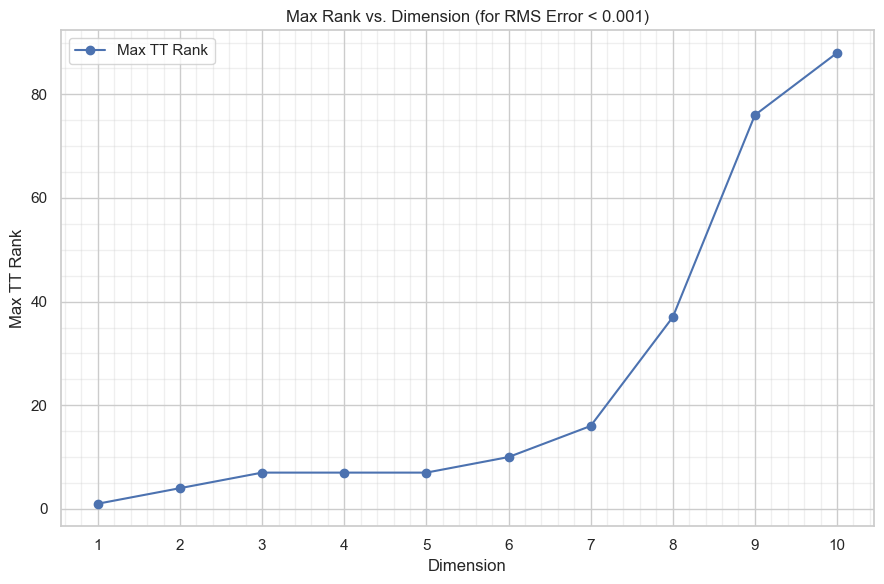

In [112]:
fig, ax = plt.subplots(figsize=(9,6), tight_layout=True)

ax.plot(dimensions, max_ranks, 'o-', label='Max TT Rank', color='C0')

ax.set_title('Max Rank vs. Dimension (for RMS Error < 0.001)')
ax.set_xlabel('Dimension')
ax.set_ylabel('Max TT Rank')

ax.set_xticks(dimensions)

ax.grid(visible=True, which='major')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.3)
plt.minorticks_on()
plt.legend()
plt.show()
plt.close()

**RMS Error and Offline Compute Time**

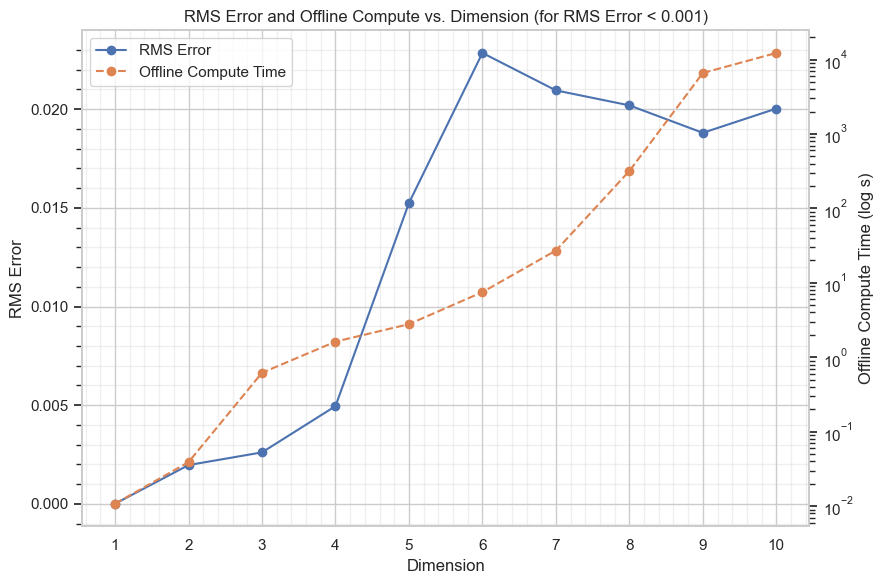

In [123]:
fig, ax = plt.subplots(figsize=(9,6), tight_layout=True)

error_line = ax.plot(dimensions, rms_errors, 'o-', color='C0')
ax2 = ax.twinx()
offline_times_line = ax2.plot(dimensions, offline_times, 'o--', color='C1')

ax.set_title('RMS Error and Offline Compute vs. Dimension (for RMS Error < 0.001)')
ax.set_xlabel('Dimension')
ax.set_ylabel('RMS Error')
# ax.set_yscale('log')
ax2.set_ylabel('Offline Compute Time (log s)')
ax2.grid(visible=False)
ax2.set_yscale('log')

ax.set_xticks(dimensions)
ax.grid(visible=True, which='major')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.3)
ax.minorticks_on()

ax.legend([error_line[0], offline_times_line[0]], ['RMS Error', 'Offline Compute Time'], loc='upper left')

plt.show()
plt.close()

**RMS Error and Online Compute Time**


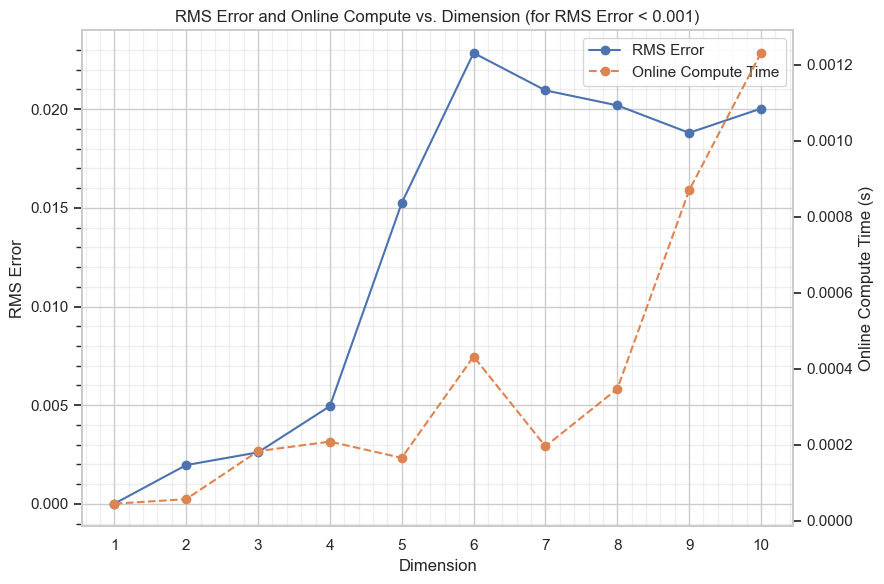

In [145]:
fig, ax = plt.subplots(figsize=(9,6), tight_layout=True)

error_line = ax.plot(dimensions, rms_errors[::-1], 'o-', color='C0')
ax2 = ax.twinx()
online_compute_line = ax2.plot(dimensions, online_times[::-1], 'o--', color='C1')

ax.set_title('RMS Error and Online Compute vs. Dimension (for RMS Error < 0.001)')
ax.set_xlabel('Dimension')
ax.set_ylabel('RMS Error')
ax2.set_ylabel('Online Compute Time (s)')
ax2.grid(visible=False)

ax.set_xticks(dimensions)
ax.grid(visible=True, which='major')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.3)
ax.minorticks_on()

ax.legend([error_line[0], online_compute_line[0]], ['RMS Error', 'Online Compute Time'])
plt.show()
plt.close()

**N Samples vs. Dimension**

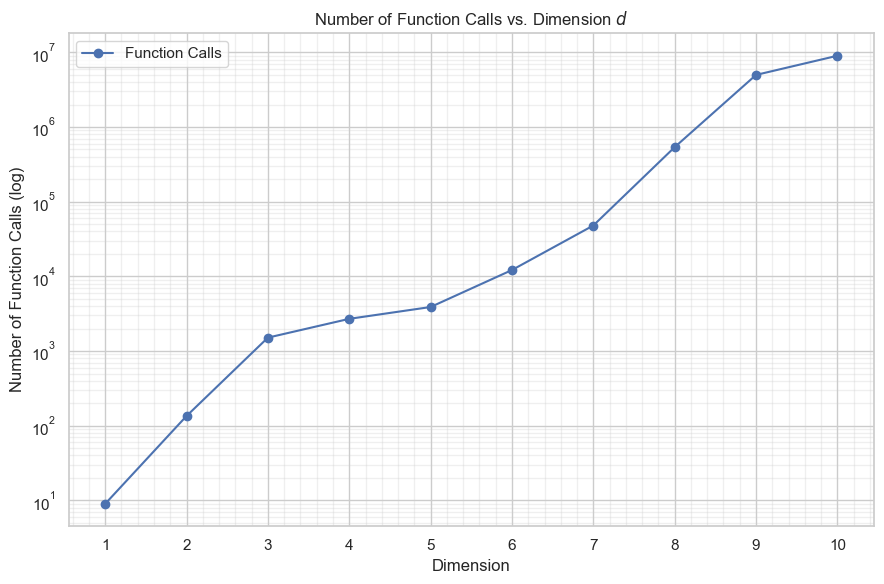

In [128]:
fig, ax = plt.subplots(figsize=(9, 6), tight_layout=True)

error_line = ax.plot(dimensions, n_samples, 'o-', color='C0', label='Function Calls')

ax.set_title('Number of Function Calls vs. Dimension $d$')
ax.set_xlabel('Dimension')
ax.set_ylabel('Number of Function Calls (log)')

ax.set_xticks(dimensions)
ax.grid(visible=True, which='major')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.3)
ax.minorticks_on()
ax.set_yscale('log')

ax.legend()

# ax.legend([error_line[0], online_compute_line[0]], ['RMS Error', 'Online Compute Time'])
plt.show()
plt.close()

**Rank Sweep**

In [129]:
with open('rank_sweep_results.json', 'r') as f:
    rank_sweep_results = json.load(f)

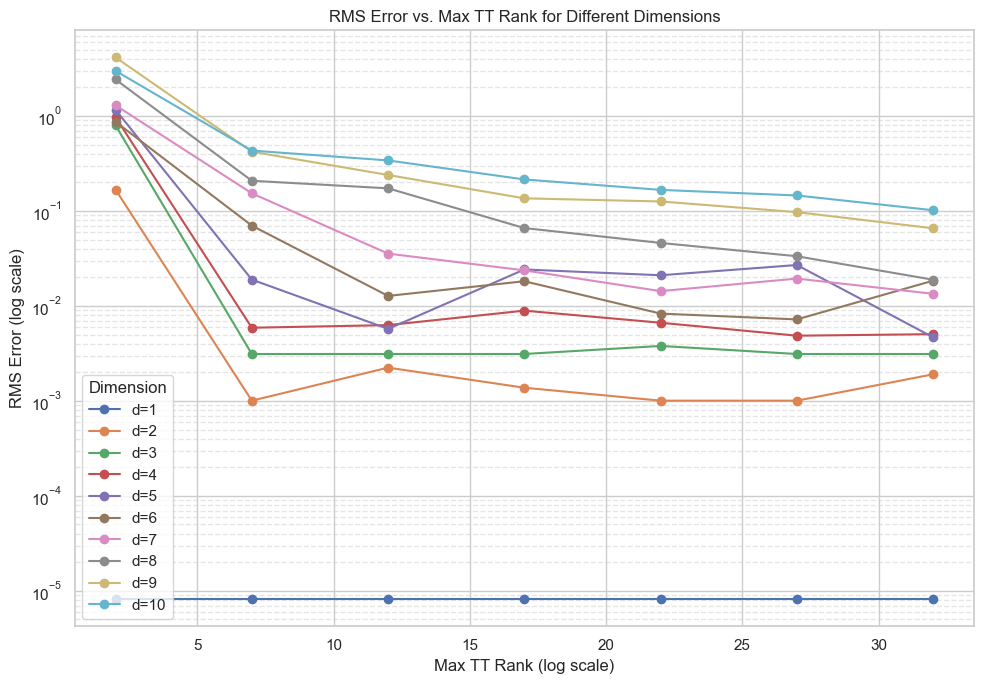

In [134]:
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)

ranks = rank_sweep_results['ranks']
dimensions = rank_sweep_results['dimensions']
rms_errors_by_dim = rank_sweep_results['rms_errors']

for i, d in enumerate(dimensions):
    ax.plot(ranks, rms_errors_by_dim[i], 'o-', label=f'd={d}')

# ax.axhline(y=1E-3, color='r', linestyle='--', label='Target Error (1E-3)')

ax.set_title('RMS Error vs. Max TT Rank for Different Dimensions')
ax.set_xlabel('Max TT Rank (log scale)')
ax.set_ylabel('RMS Error (log scale)')
# ax.set_xscale('log', base=2)
ax.set_yscale('log')

ax.grid(visible=True, which='major', linestyle='-')
ax.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
ax.legend(title="Dimension")
plt.show()
plt.close()

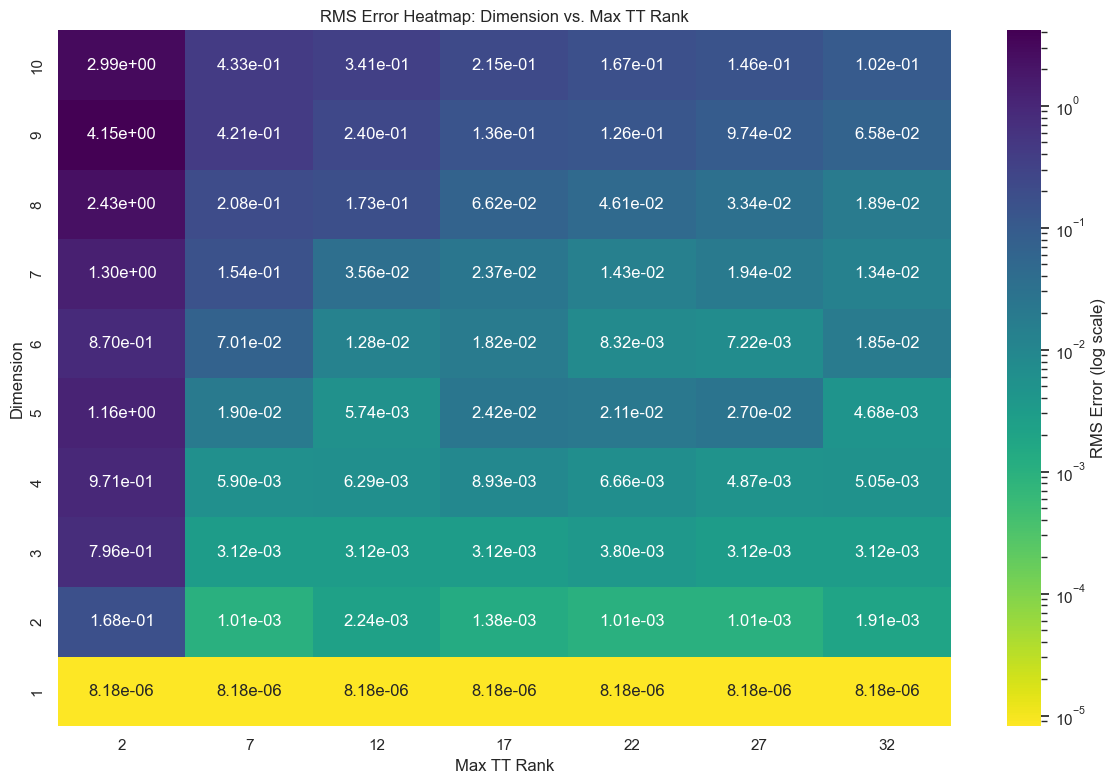

In [141]:
ranks = rank_sweep_results['ranks']
dimensions = rank_sweep_results['dimensions'][::-1]
rms_errors_by_dim = np.array(rank_sweep_results['rms_errors'])[::-1]

fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)

min_error = np.min(rms_errors_by_dim[np.nonzero(rms_errors_by_dim)])
norm = LogNorm(vmin=min_error, vmax=rms_errors_by_dim.max())

sns.heatmap(
    rms_errors_by_dim,
    xticklabels=ranks,
    yticklabels=dimensions,
    annot=True,
    fmt=".2e",
    cmap="viridis_r",
    norm=norm,
    ax=ax,
    cbar_kws={'label': 'RMS Error (log scale)'}
)

ax.set_title('RMS Error Heatmap: Dimension vs. Max TT Rank')
ax.set_xlabel('Max TT Rank')
ax.set_ylabel('Dimension')

plt.show()
plt.close()

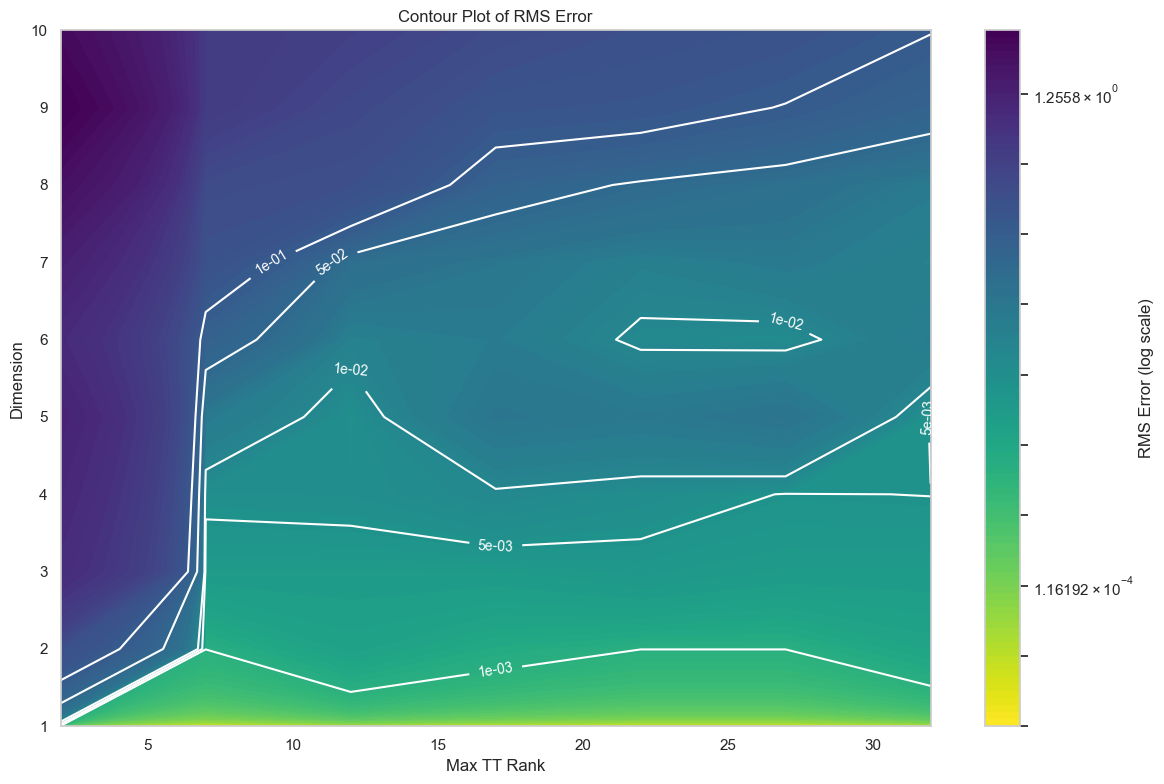

In [139]:
ranks = rank_sweep_results['ranks']
dimensions = rank_sweep_results['dimensions']
rms_errors_by_dim = np.array(rank_sweep_results['rms_errors'])

R, D = np.meshgrid(ranks, dimensions)

fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)

levels = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

min_error = np.min(rms_errors_by_dim[np.nonzero(rms_errors_by_dim)])
cf = ax.contourf(R, D, rms_errors_by_dim, cmap="viridis_r", norm=LogNorm(vmin=min_error, vmax=rms_errors_by_dim.max()), levels=np.logspace(np.log10(min_error), np.log10(rms_errors_by_dim.max()), 100))
fig.colorbar(cf, ax=ax, label='RMS Error (log scale)')

cs = ax.contour(R, D, rms_errors_by_dim, levels=levels, colors='white')
ax.clabel(cs, inline=True, fontsize=10, fmt='%.0e')

ax.set_title('Contour Plot of RMS Error')
ax.set_xlabel('Max TT Rank')
ax.set_ylabel('Dimension')

plt.show()
plt.close()